ENHANCED 3-PHASE PIPELINE
Maintains your original Phase 1 → Phase 2 → Phase 3 structure
but with O*NET integration and smart imputation fixes

In [17]:
import os
import pandas as pd
import numpy as np
import requests
import logging
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

logging.basicConfig(level=logging.INFO, format="%(levelname)s - %(message)s")

# Configuration
DATA_DIR = Path(r"C:\Users\acer\OneDrive\Labor Market Project\Data")
ENHANCED_DIR = DATA_DIR / "Enhanced_Sources"
OUTPUTS_DIR = DATA_DIR.parent / "Outputs"

# Create directories
ENHANCED_DIR.mkdir(exist_ok=True)
OUTPUTS_DIR.mkdir(exist_ok=True)

# File paths for each phase
ENHANCED_PHASE1_OUTPUT = DATA_DIR / "SOC_Categories_Enhanced_Phase1.xlsx"
ENHANCED_PHASE2_OUTPUT = DATA_DIR / "SOC_Complementarity_Enhanced_Phase2.xlsx"  
ENHANCED_PHASE3_OUTPUT = OUTPUTS_DIR / "Enhanced_Final_Job_Classification.xlsx"

# ============================================================================
# ENHANCED PHASE 1: COMPREHENSIVE DATA COLLECTION AND INTEGRATION
# ============================================================================

def run_enhanced_phase1():
    """
    Enhanced Phase 1: Your original logic + O*NET integration + smart imputation
    """
     
    # Step 1: Run your original Phase 1 logic first
    print("\nStep 1: Loading your original data sources...")
    
    # Your original category mapping
    CATEGORY_MAP = {
        "Face-to-Face_Discussions_with_Individuals_and_Within_Teams.xlsx": "Communication",
        "Public_Speaking.xlsx": "Communication",
        "Work_Outcomes_and_Results_of_Other_Workers.xlsx": "Responsibility",
        "Health_and_Safety_of_Other_Workers.xlsx": "Responsibility",
        "Determine_Tasks_Priorities_and_Goals.xlsx": "Routine",
        "Outdoors_Exposed_to_All_Weather_Conditions.xlsx": "Physical",
        "Physical_Proximity.xlsx": "Physical",
        "Consequence_of_Error.xlsx": "Criticality",
        "Frequency_of_Decision_Making.xlsx": "Criticality",
        "Degree_of_Automation.xlsx": "Routine",
        "Freedom_to_Make_Decisions.xlsx": "Criticality",
        "AIOE_DataAppendix.xlsx": "AIOE"
    }
    
    JOB_ZONE_FILES = {
        "Job_Zone_One_Little_or_No_Preparation_Needed.xlsx": 1,
        "Job_Zone_Two_Some_Preparation_Needed.xlsx": 2,
        "Job_Zone_Three_Medium_Preparation_Needed.xlsx": 3,
        "Job_Zone_Four_Considerable_Preparation_Needed.xlsx": 4,
        "Job_Zone_Five_Extensive_Preparation_Needed.xlsx": 5
    }
    
    # Load your original files (same logic as your Phase 1)
    all_dfs = []
    
    # Job Zone files → Skills
    for file_name, job_zone_value in JOB_ZONE_FILES.items():
        file_path = DATA_DIR / file_name
        if file_path.exists():
            try:
                df = pd.read_excel(file_path, header=None, skiprows=4)
                df.columns = ["SOC_Code", "Occupation"]
                df["Skills"] = job_zone_value
                df = df.dropna(subset=["SOC_Code", "Occupation"])
                all_dfs.append(df[["SOC_Code", "Occupation", "Skills"]])
                print(f"    Loaded {file_name}")
            except Exception as e:
                print(f"    Warning: Could not load {file_name}: {e}")
    
    # Category files → Work characteristics  
    for file_name, category_name in CATEGORY_MAP.items():
        file_path = DATA_DIR / file_name
        if file_path.exists():
            try:
                if file_name == "AIOE_DataAppendix.xlsx":
                    df = pd.read_excel(file_path, sheet_name="Appendix A")
                    df.columns = [col.strip() for col in df.columns]
                    df = df.rename(columns={"SOC Code": "SOC_Code", "Occupation Title": "Occupation"})
                    df = df[["SOC_Code", "Occupation", "AIOE"]]
                elif file_name in ["Consequence_of_Error.xlsx", "Frequency_of_Decision_Making.xlsx", 
                                   "Freedom_to_Make_Decisions.xlsx", "Determine_Tasks_Priorities_and_Goals.xlsx", 
                                   "Degree_of_Automation.xlsx"]:
                    df = pd.read_excel(file_path, header=None, skiprows=3)
                    df.columns = [category_name, "Job Zone", "SOC_Code", "Occupation"]
                    df = df.dropna(subset=["SOC_Code", "Occupation"])
                    df[category_name] = pd.to_numeric(df[category_name], errors='coerce')
                    df = df[["SOC_Code", "Occupation", category_name]]
                else:
                    df = pd.read_excel(file_path, header=None, skiprows=2)
                    df.columns = [category_name, "Context", "SOC_Code", "Occupation"]
                    df = df.dropna(subset=["SOC_Code", "Occupation"])
                    df[category_name] = pd.to_numeric(df[category_name], errors='coerce')
                    df = df[["SOC_Code", "Occupation", category_name]]
                
                all_dfs.append(df)
                print(f"    Loaded {file_name}")
            except Exception as e:
                print(f"    Warning: Could not load {file_name}: {e}")
    
    if not all_dfs:
        print("ERROR: No data files found!")
        return None
    
    # Merge your original data (same as your Phase 1)
    raw_df = pd.concat(all_dfs, ignore_index=True)
    raw_df['SOC_Code'] = raw_df['SOC_Code'].astype(str).str.replace(r'\.\d+$', '', regex=True)
    original_df = raw_df.groupby(["SOC_Code", "Occupation"]).median().reset_index()
    
    print(f"    Original data: {len(original_df)} occupations")
    
    # Step 2: O*NET Enhancement (if files exist)
    print(f"\nStep 2: O*NET data enhancement...")
    
    onet_enhancements = {}
    
    if ENHANCED_DIR.exists() and any(ENHANCED_DIR.glob("*.txt")):
        try:
            # Load O*NET work context data
            wc_file = ENHANCED_DIR / "work_context.txt"
            if wc_file.exists():
                wc_df = pd.read_csv(wc_file, sep='\t', encoding='utf-8', low_memory=False)
                print(f"    Loaded O*NET work context: {len(wc_df):,} rows")
                
                # Extract work characteristics from O*NET
                onet_mappings = {
                    'Communication': ['4.A.4.a.5', '4.A.4.a.8'],
                    'Responsibility': ['4.A.4.b.4', '4.A.4.b.3'],
                    'Physical': ['4.A.3.a.3', '4.A.3.b.1'],
                    'Criticality': ['4.A.3.a.2', '4.A.4.b.1'],
                    'Routine': ['4.A.3.a.4', '4.A.4.a.4']
                }
                
                for category, element_ids in onet_mappings.items():
                    category_data = []
                    for element_id in element_ids:
                        element_data = wc_df[wc_df['Element ID'] == element_id].copy()
                        if not element_data.empty:
                            element_data['Data Value'] = pd.to_numeric(element_data['Data Value'], errors='coerce')
                            element_data = element_data.dropna(subset=['Data Value'])
                            if not element_data.empty:
                                category_data.append(element_data)
                    
                    if category_data:
                        combined = pd.concat(category_data, ignore_index=True)
                        grouped = combined.groupby('O*NET-SOC Code')['Data Value'].mean().reset_index()
                        
                        # Standardize SOC codes
                        def standardize_soc(soc_code):
                            if pd.isna(soc_code):
                                return None
                            soc_str = str(soc_code).strip()
                            if '.' in soc_str:
                                soc_str = soc_str.split('.')[0]
                            soc_clean = ''.join(c for c in soc_str if c.isdigit() or c == '-')
                            if '-' not in soc_clean and len(soc_clean) >= 6:
                                soc_clean = soc_clean[:2] + '-' + soc_clean[2:]
                            return soc_clean if len(soc_clean) >= 7 else None
                        
                        grouped['SOC_Code'] = grouped['O*NET-SOC Code'].apply(standardize_soc)
                        grouped = grouped.dropna(subset=['SOC_Code'])
                        grouped[category] = grouped['Data Value']
                        
                        onet_enhancements[category] = grouped[['SOC_Code', category]]
                        print(f"    Extracted O*NET {category}: {len(grouped)} occupations")
            
            # Load O*NET job zones for Skills
            jz_file = ENHANCED_DIR / "job_zones.txt"
            if jz_file.exists():
                jz_df = pd.read_csv(jz_file, sep='\t', encoding='utf-8')
                jz_df['SOC_Code'] = jz_df['O*NET-SOC Code'].apply(lambda x: str(x).split('.')[0] if pd.notna(x) else None)
                jz_df['Skills'] = pd.to_numeric(jz_df['Job Zone'], errors='coerce')
                jz_clean = jz_df[['SOC_Code', 'Skills']].dropna()
                
                if not jz_clean.empty:
                    onet_enhancements['Skills'] = jz_clean
                    print(f"    Extracted O*NET Skills: {len(jz_clean)} occupations")
    
        except Exception as e:
            print(f"    Warning: O*NET processing failed: {e}")
    else:
        print("    O*NET data not available, using original data only")
    
    # Step 3: Smart Integration
    print(f"\nStep 3: Smart data integration...")
    
    enhanced_df = original_df.copy()
    enhanced_df['Data_Source'] = 'Original'
    
    # Merge O*NET enhancements where original data is missing
    for category, onet_df in onet_enhancements.items():
        if category in enhanced_df.columns:
            # Find where original data is missing
            missing_mask = enhanced_df[category].isnull()
            
            if missing_mask.sum() > 0:
                # Merge O*NET data
                merge_df = enhanced_df[['SOC_Code']].merge(onet_df, on='SOC_Code', how='left', suffixes=('', '_ONET'))
                
                # Fill missing values with O*NET data
                onet_col = category + '_ONET' if category + '_ONET' in merge_df.columns else category
                if onet_col in merge_df.columns:
                    fill_mask = missing_mask & merge_df[onet_col].notna()
                    enhanced_df.loc[fill_mask, category] = merge_df.loc[fill_mask, onet_col]
                    
                    filled_count = fill_mask.sum()
                    print(f"    Filled {filled_count} missing {category} values with O*NET data")
    
    # Step 4: Smart imputation for remaining gaps
    print(f"\nStep 4: Smart imputation for remaining gaps...")
    
    enhanced_df['SOC_Family'] = enhanced_df['SOC_Code'].str[:2]
    
    # Family-based imputation
    analysis_cols = ['AIOE', 'Communication', 'Responsibility', 'Physical', 'Criticality', 'Routine', 'Skills']
    
    for col in analysis_cols:
        if col in enhanced_df.columns:
            missing_mask = enhanced_df[col].isnull()
            if missing_mask.sum() > 0:
                # Use SOC family averages
                family_means = enhanced_df.groupby('SOC_Family')[col].mean()
                enhanced_df.loc[missing_mask, col] = enhanced_df.loc[missing_mask, 'SOC_Family'].map(family_means)
                
                # Overall mean fallback
                still_missing = enhanced_df[col].isnull()
                if still_missing.sum() > 0:
                    overall_mean = enhanced_df[col].mean()
                    enhanced_df.loc[still_missing, col] = overall_mean
                
                imputed_count = missing_mask.sum() - enhanced_df[col].isnull().sum()
                if imputed_count > 0:
                    print(f"    Smart imputed {imputed_count} {col} values using SOC families")
    
    # Step 5: Normalize to 0-100 scale (same as your original)
    print(f"\nStep 5: Normalizing scores to 0-100 scale...")
    
    for col in ['Communication', 'Responsibility', 'Physical', 'Criticality', 'Routine', 'Skills']:
        if col in enhanced_df.columns:
            col_min = enhanced_df[col].min()
            col_max = enhanced_df[col].max()
            if col_max != col_min:
                enhanced_df[col] = 100 * (enhanced_df[col] - col_min) / (col_max - col_min)
            else:
                enhanced_df[col] = 0
    
    # Step 6: Save Enhanced Phase 1 output
    enhanced_df.to_excel(ENHANCED_PHASE1_OUTPUT, index=False)
    
    print(f"\nENHANCED PHASE 1 COMPLETE!")
    print(f"Dataset: {len(enhanced_df)} occupations")
    print(f"Complete cases: {len(enhanced_df[analysis_cols].dropna())}")
    print(f"Saved to: {ENHANCED_PHASE1_OUTPUT}")
    
    return enhanced_df

run_enhanced_phase1()


Step 1: Loading your original data sources...
    Loaded Job_Zone_One_Little_or_No_Preparation_Needed.xlsx
    Loaded Job_Zone_Two_Some_Preparation_Needed.xlsx
    Loaded Job_Zone_Three_Medium_Preparation_Needed.xlsx
    Loaded Job_Zone_Four_Considerable_Preparation_Needed.xlsx
    Loaded Job_Zone_Five_Extensive_Preparation_Needed.xlsx
    Loaded Face-to-Face_Discussions_with_Individuals_and_Within_Teams.xlsx
    Loaded Public_Speaking.xlsx
    Loaded Work_Outcomes_and_Results_of_Other_Workers.xlsx
    Loaded Health_and_Safety_of_Other_Workers.xlsx
    Loaded Determine_Tasks_Priorities_and_Goals.xlsx
    Loaded Outdoors_Exposed_to_All_Weather_Conditions.xlsx
    Loaded Physical_Proximity.xlsx
    Loaded Consequence_of_Error.xlsx
    Loaded Frequency_of_Decision_Making.xlsx
    Loaded Degree_of_Automation.xlsx
    Loaded Freedom_to_Make_Decisions.xlsx
    Loaded AIOE_DataAppendix.xlsx
    Original data: 1123 occupations

Step 2: O*NET data enhancement...
    Loaded O*NET work context: 

,SOC_Code,Occupation,Skills,Communication,Responsibility,Routine,Physical,Criticality,AIOE,Data_Source,SOC_Family
0,11-1011,Chief Executives,100.0,73.750000,86.904762,77.118644,30.000000,87.179487,1.334246,Original,11
1,11-1011,Chief Sustainability Officers,100.0,67.500000,51.190476,55.084746,33.333333,57.692308,0.961682,Original,11
2,11-1021,General and Operations Managers,75.0,63.750000,86.904762,77.118644,48.333333,93.589744,0.574877,Original,11
3,11-1031,Legislators,75.0,67.465278,69.433422,66.839297,37.366255,68.186135,0.961682,Original,11
4,11-2011,Advertising and Promotions Managers,75.0,65.000000,48.809524,60.169492,37.222222,69.230769,1.294387,Original,11
...,...,...,...,...,...,...,...,...,...,...,...
1118,53-7073,Wellhead Pumpers,25.0,41.875000,48.809524,67.796610,56.666667,79.487179,-1.091197,Original,53
1119,53-7081,Refuse and Recyclable Material Collectors,25.0,23.750000,30.952381,55.084746,67.222222,41.025641,-1.283373,Original,53
1120,53-7111,Shuttle Car Operators,50.0,50.573980,64.382896,57.627119,64.693878,68.498168,-1.351998,Original,53
1121,53-7121,"Tank Car, Truck, and Ship Loaders",25.0,57.500000,76.785714,50.000000,77.777778,80.769231,-1.387760,Original,53


Phase 2: Original Theta Calculation 

In [18]:
# ============================================================================
# ENHANCED PHASE 2: THETA CALCULATION WITH QUALITY TRACKING
# ============================================================================

def run_enhanced_phase2():
    """
    Enhanced Phase 2: Your original Theta calculation + quality tracking
    """
    
    
    # Load Enhanced Phase 1 results
    try:
        enhanced_df = pd.read_excel(ENHANCED_PHASE1_OUTPUT)
        print(f"Loaded Enhanced Phase 1 data: {len(enhanced_df)} occupations")
    except FileNotFoundError:
        print("ERROR: Enhanced Phase 1 output not found. Run Enhanced Phase 1 first.")
        return None
    
    # Calculate Theta (same formula as your original)
    print(f"\nCalculating Theta using your original formula...")
    
    enhanced_df["Theta"] = (
        enhanced_df["Communication"] +
        enhanced_df["Responsibility"] +  
        enhanced_df["Physical"] +
        enhanced_df["Criticality"] +
        enhanced_df["Skills"] -
        enhanced_df["Routine"]
    )
    
    # Normalize Theta to 0-100 scale (same as your original)
    theta_min = enhanced_df["Theta"].min()
    theta_max = enhanced_df["Theta"].max()
    
    if theta_max != theta_min:
        enhanced_df["Theta_Normalized"] = 100 * (enhanced_df["Theta"] - theta_min) / (theta_max - theta_min)
    else:
        enhanced_df["Theta_Normalized"] = 0
    
    # Add quality tracking
    required_cols = ['Communication', 'Responsibility', 'Physical', 'Criticality', 'Routine', 'Skills']
    enhanced_df['Theta_Quality'] = 'Complete'
    
    # Track if any components were enhanced/imputed
    if 'Data_Source' in enhanced_df.columns:
        enhanced_df.loc[enhanced_df['Data_Source'] != 'Original', 'Theta_Quality'] = 'Enhanced'
    
    print(f"Theta calculated for {len(enhanced_df)} occupations")
    print(f"Theta range: {theta_min:.2f} to {theta_max:.2f}")
    
    quality_dist = enhanced_df['Theta_Quality'].value_counts()
    print("Theta quality distribution:")
    for quality, count in quality_dist.items():
        print(f"    {quality}: {count}")
    
    # Save Enhanced Phase 2 output  
    enhanced_df.to_excel(ENHANCED_PHASE2_OUTPUT, index=False)
    
    print(f"\nENHANCED PHASE 2 COMPLETE!")
    print(f"Saved to: {ENHANCED_PHASE2_OUTPUT}")
    
    return enhanced_df

run_enhanced_phase2()

Loaded Enhanced Phase 1 data: 1123 occupations

Calculating Theta using your original formula...
Theta calculated for 1123 occupations
Theta range: 20.00 to 353.00
Theta quality distribution:
    Complete: 1123

ENHANCED PHASE 2 COMPLETE!
Saved to: C:\Users\acer\OneDrive\Labor Market Project\Data\SOC_Complementarity_Enhanced_Phase2.xlsx


,SOC_Code,Occupation,Skills,Communication,Responsibility,Routine,Physical,Criticality,AIOE,Data_Source,SOC_Family,Theta,Theta_Normalized,Theta_Quality
0,11-1011,Chief Executives,100.0,73.750000,86.904762,77.118644,30.000000,87.179487,1.334246,Original,11,300.715605,84.299605,Complete
1,11-1011,Chief Sustainability Officers,100.0,67.500000,51.190476,55.084746,33.333333,57.692308,0.961682,Original,11,254.631371,70.460280,Complete
2,11-1021,General and Operations Managers,75.0,63.750000,86.904762,77.118644,48.333333,93.589744,0.574877,Original,11,290.459195,81.219554,Complete
3,11-1031,Legislators,75.0,67.465278,69.433422,66.839297,37.366255,68.186135,0.961682,Original,11,250.611792,69.253180,Complete
4,11-2011,Advertising and Promotions Managers,75.0,65.000000,48.809524,60.169492,37.222222,69.230769,1.294387,Original,11,235.093024,64.592816,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,53-7073,Wellhead Pumpers,25.0,41.875000,48.809524,67.796610,56.666667,79.487179,-1.091197,Original,53,184.041760,49.261867,Complete
1119,53-7081,Refuse and Recyclable Material Collectors,25.0,23.750000,30.952381,55.084746,67.222222,41.025641,-1.283373,Original,53,132.865498,33.893381,Complete
1120,53-7111,Shuttle Car Operators,50.0,50.573980,64.382896,57.627119,64.693878,68.498168,-1.351998,Original,53,240.521803,66.223106,Complete
1121,53-7121,"Tank Car, Truck, and Ship Loaders",25.0,57.500000,76.785714,50.000000,77.777778,80.769231,-1.387760,Original,53,267.832723,74.424711,Complete


Phase 3: Classification and Standard Scaling

In [19]:
import os
import pandas as pd
import numpy as np
import logging
from pathlib import Path
from sklearn.preprocessing import StandardScaler

logging.basicConfig(level=logging.INFO, format="%(levelname)s - %(message)s")

# Configuration
DATA_DIR = Path(r"C:\Users\acer\OneDrive\Labor Market Project\Data")
OUTPUTS_DIR = DATA_DIR.parent / "Outputs"
ENHANCED_PHASE2_OUTPUT = DATA_DIR / "SOC_Complementarity_Enhanced_Phase2.xlsx"
ENHANCED_PHASE3_OUTPUT = OUTPUTS_DIR / "Enhanced_Final_Job_Classification.xlsx"

def run_enhanced_phase3():
    """
    Enhanced Phase 3: Classification with transparency and standard scaling.
    """
    
    # Load Enhanced Phase 2 results
    try:
        enhanced_df = pd.read_excel(ENHANCED_PHASE2_OUTPUT)
        print(f"Loaded Enhanced Phase 2 data: {len(enhanced_df)} occupations")
    except FileNotFoundError:
        print("ERROR: Enhanced Phase 2 output not found. Run Enhanced Phase 2 first.")
        return None
        
    # Perform Standard Scaling
    print("\nPerforming standard scaling on AIOE and Theta scores...")
    scaler = StandardScaler()
    
    # Scale AIOE and save to a new column
    enhanced_df['AIOE_Scaled'] = scaler.fit_transform(enhanced_df[['AIOE']])
    
    # Scale Theta_Normalized and save to a new column
    enhanced_df['Theta_Normalized_Scaled'] = scaler.fit_transform(enhanced_df[['Theta_Normalized']])
    
    # Calculate medians for classification
    median_aioe = enhanced_df["AIOE"].median()
    median_theta = enhanced_df["Theta_Normalized"].median()
    
    # Create exposure and complementarity categories
    enhanced_df["Exposure"] = np.where(enhanced_df["AIOE"] > median_aioe, "High", "Low")
    enhanced_df["Complementarity"] = np.where(enhanced_df["Theta_Normalized"] > median_theta, "High", "Low")
    
    # Classification function
    def enhanced_classification(row):
        if row["Exposure"] == "Low":
            return "Low Exposure (Minimal Impact)"
        elif row["Exposure"] == "High" and row["Complementarity"] == "High":
            return "High Exposure, High Complementarity (Augmentation)"
        elif row["Exposure"] == "High" and row["Complementarity"] == "Low":
            return "High Exposure, Low Complementarity (Displacement Risk)"
        return "Unknown"
    
    enhanced_df["Classification"] = enhanced_df.apply(enhanced_classification, axis=1)
    
    # Define the final output columns
    output_cols = [
        "SOC_Code", "Occupation", "AIOE", "AIOE_Scaled", "Exposure",
        "Theta_Normalized", "Theta_Normalized_Scaled", "Complementarity",
        "Classification", "Methodology"
    ]
    
    # Filter for only the columns that exist in the DataFrame
    final_cols = [col for col in output_cols if col in enhanced_df.columns]
    final_df = enhanced_df[final_cols].copy()
    
    # Save final results
    final_df.to_excel(ENHANCED_PHASE3_OUTPUT, index=False)
    
    print(f"\nENHANCED PHASE 3 COMPLETE!")
    print(f"Final dataset: {len(final_df)} occupations")
    print(f"Saved to: {ENHANCED_PHASE3_OUTPUT}")
    print("\nPreview of final output:")
    print(final_df.head())
    
    return final_df

if __name__ == "__main__":
    run_enhanced_phase3()

Loaded Enhanced Phase 2 data: 1123 occupations

Performing standard scaling on AIOE and Theta scores...

ENHANCED PHASE 3 COMPLETE!
Final dataset: 1123 occupations
Saved to: C:\Users\acer\OneDrive\Labor Market Project\Outputs\Enhanced_Final_Job_Classification.xlsx

Preview of final output:
  SOC_Code                           Occupation      AIOE  AIOE_Scaled  \
0  11-1011                     Chief Executives  1.334246     1.302322   
1  11-1011        Chief Sustainability Officers  0.961682     0.908207   
2  11-1021      General and Operations Managers  0.574877     0.499027   
3  11-1031                          Legislators  0.961682     0.908207   
4  11-2011  Advertising and Promotions Managers  1.294387     1.260157   

  Exposure  Theta_Normalized  Theta_Normalized_Scaled Complementarity  \
0     High         84.299605                 1.736660            High   
1     High         70.460280                 0.840981            High   
2     High         81.219554                 

Visuals:

DataFrame for AIOE/Theta plots loaded successfully.


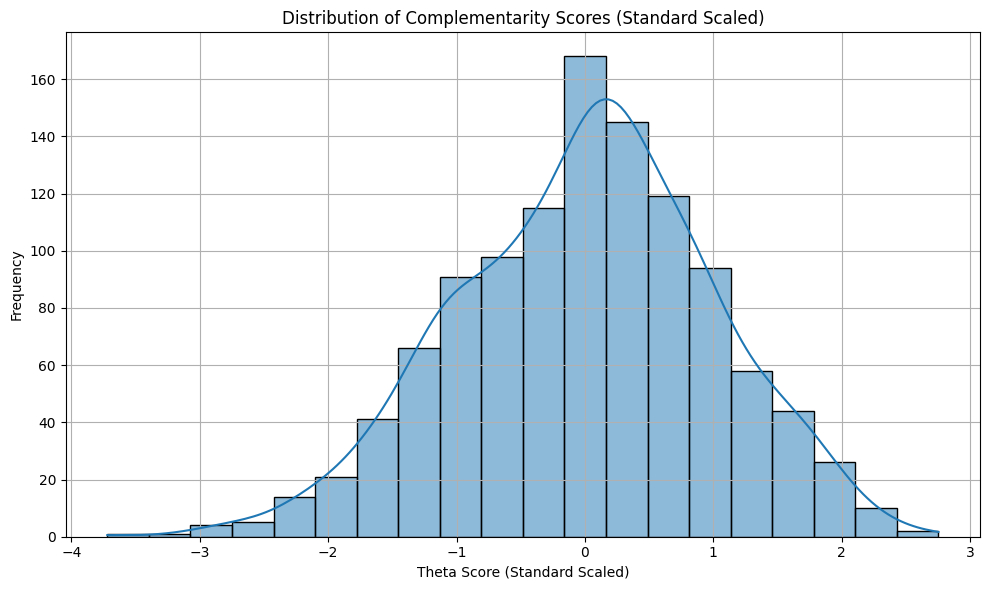

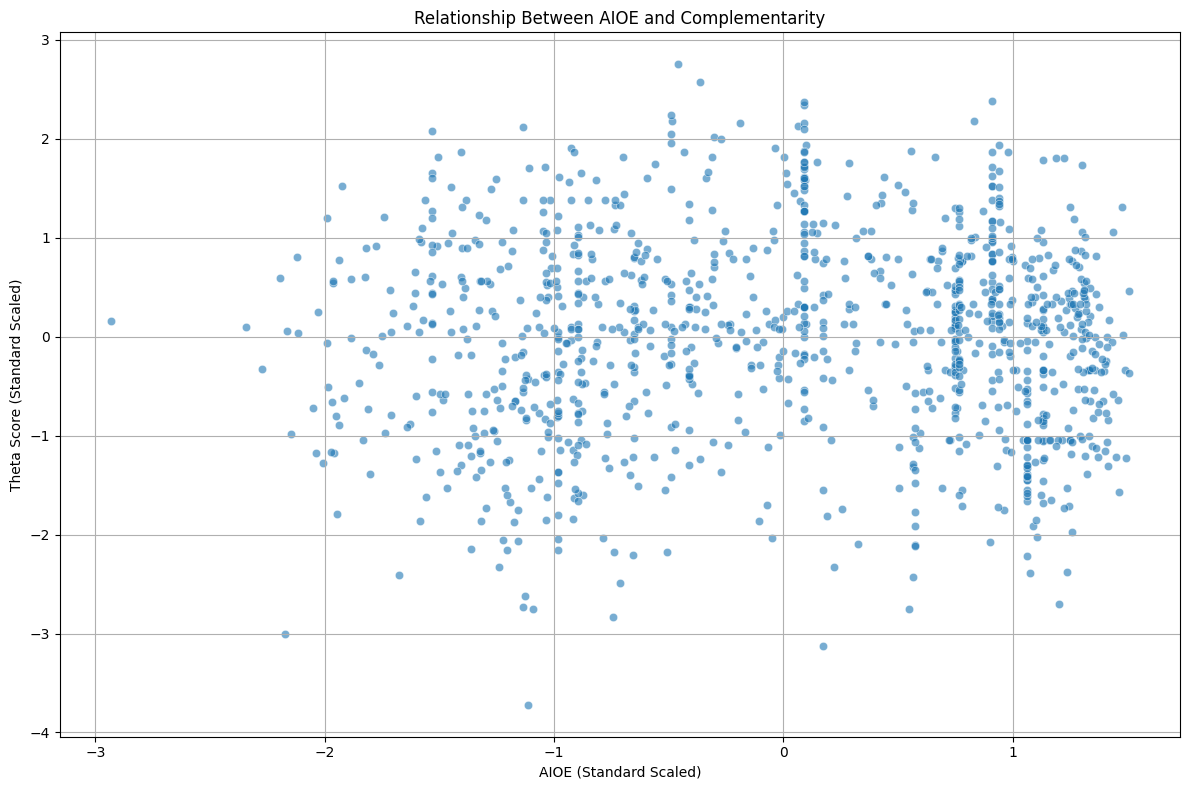


DataFrame for component plots loaded successfully.


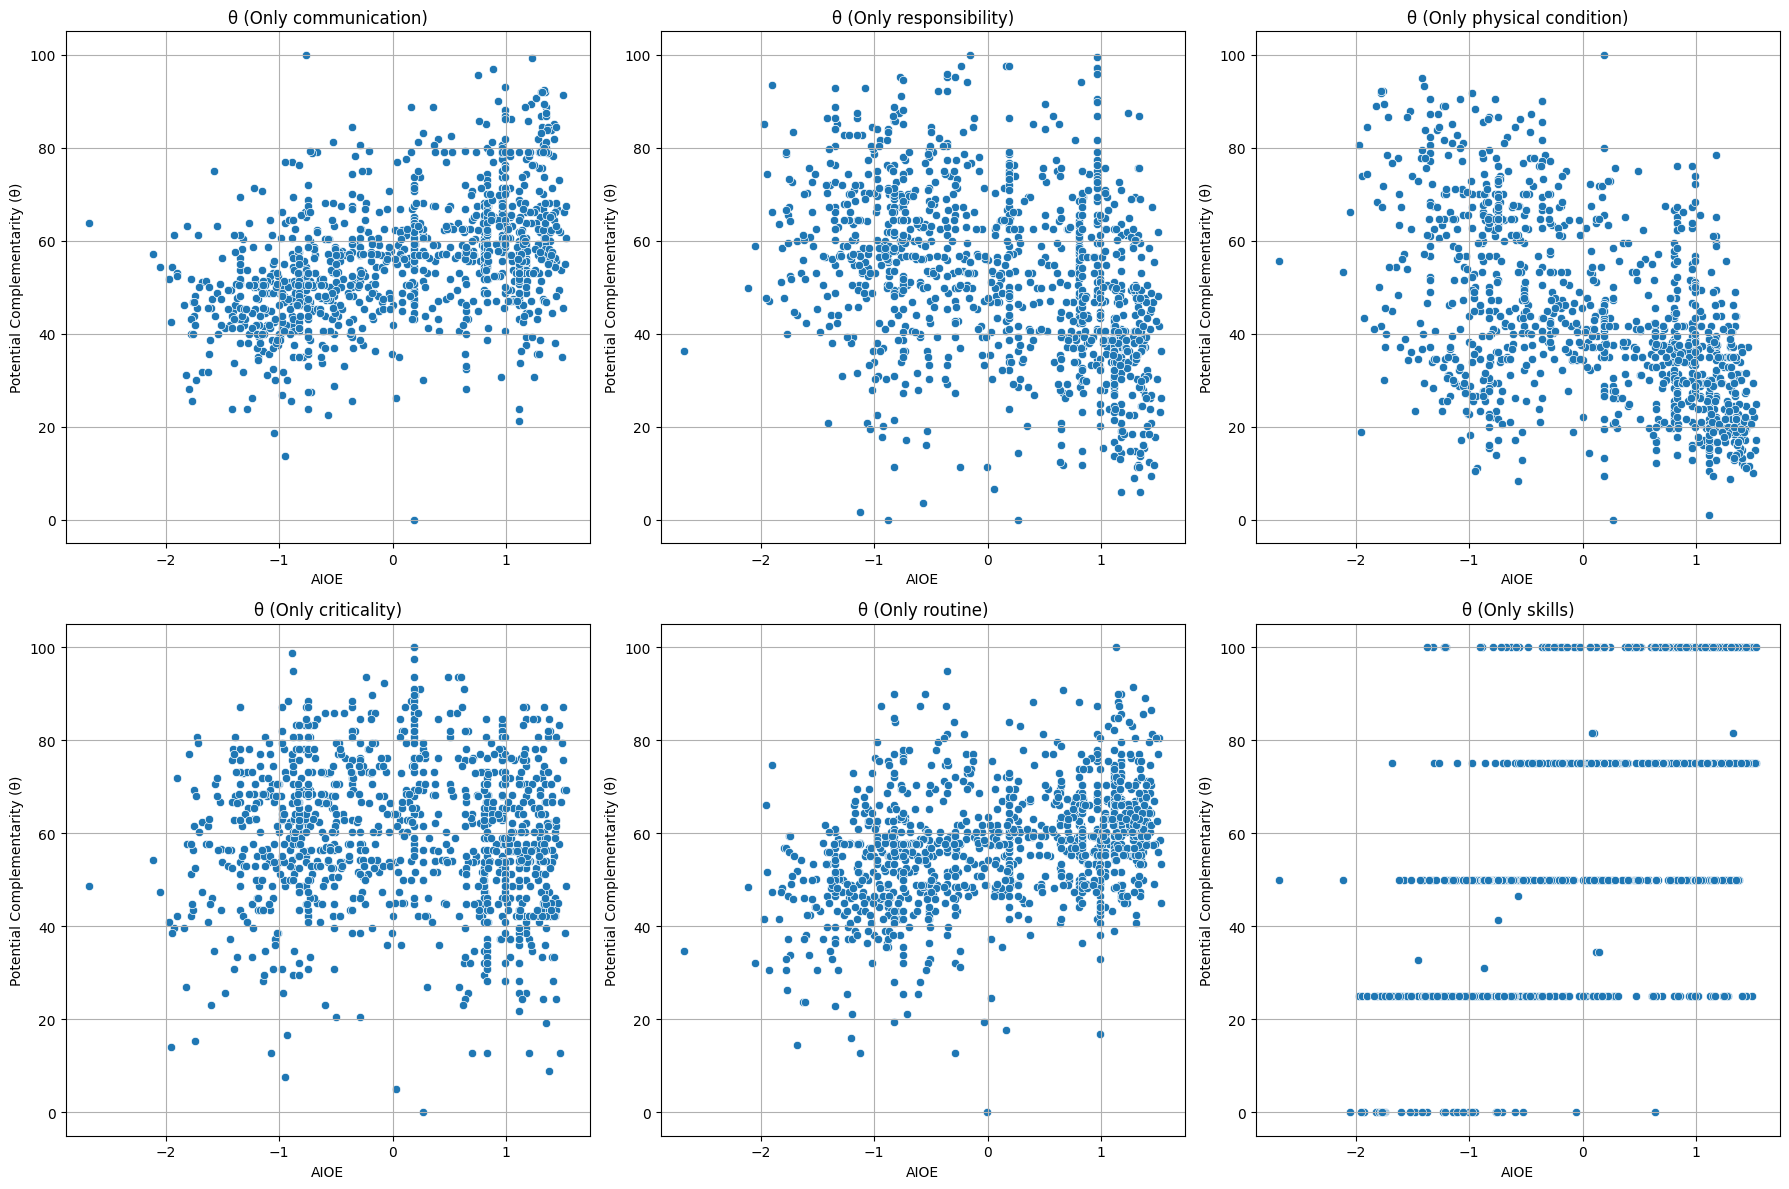

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define file paths
DATA_DIR = r"C:\Users\acer\OneDrive\Labor Market Project\Data"
OUTPUTS_DIR = r"C:\Users\acer\OneDrive\Labor Market Project\Outputs"

phase1_output_path = os.path.join(DATA_DIR, "SOC_Categories_Enhanced_Phase1.xlsx")
phase3_output_path = os.path.join(OUTPUTS_DIR, "Enhanced_Final_Job_Classification.xlsx")

# --- Generate the plots that use the Phase 3 output ---
try:
    if not os.path.exists(phase3_output_path):
        raise FileNotFoundError(f"File not found: {phase3_output_path}")

    final_df = pd.read_excel(phase3_output_path)
    print("DataFrame for AIOE/Theta plots loaded successfully.")

    # Generate Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data=final_df, x="Theta_Normalized_Scaled", bins=20, kde=True)
    plt.title("Distribution of Complementarity Scores (Standard Scaled)")
    plt.xlabel("Theta Score (Standard Scaled)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Generate main scatter plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=final_df, x="AIOE_Scaled", y="Theta_Normalized_Scaled", alpha=0.6)
    plt.title("Relationship Between AIOE and Complementarity")
    plt.xlabel("AIOE (Standard Scaled)")
    plt.ylabel("Theta Score (Standard Scaled)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(e)
    print("Please ensure the full 3-phase pipeline code was run to create the required file.")

except Exception as e:
    print(f"An error occurred while plotting the main charts: {e}")

# --- Generate the 6-panel scatter plots using the Phase 1 output ---
try:
    if not os.path.exists(phase1_output_path):
        raise FileNotFoundError(f"File not found: {phase1_output_path}")

    phase1_df = pd.read_excel(phase1_output_path)
    print("\nDataFrame for component plots loaded successfully.")
    
    components = ["Communication", "Responsibility", "Physical", "Criticality", "Routine", "Skills"]
    if not all(col in phase1_df.columns for col in components):
        missing_cols = [col for col in components if col not in phase1_df.columns]
        raise ValueError(f"Missing columns in Phase 1 data: {', '.join(missing_cols)}")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    titles = [
        "θ (Only communication)", "θ (Only responsibility)", "θ (Only physical condition)",
        "θ (Only criticality)", "θ (Only routine)", "θ (Only skills)"
    ]
    
    axes = axes.flatten()

    for i, (component, title) in enumerate(zip(components, titles)):
        sns.scatterplot(ax=axes[i], data=phase1_df, x="AIOE", y=component)
        axes[i].set_title(title)
        axes[i].set_xlabel("AIOE")
        axes[i].set_ylabel("Potential Complementarity (θ)")
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(e)
    print("Please ensure the full 3-phase pipeline code was run to create the required file.")

except Exception as e:
    print(f"An error occurred while plotting the component charts: {e}")